In [3]:
import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc
import pickle as pkl

def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
    
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)

def draw_mask(img, mask, alpha=0.5, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0
        
    return img_mask.astype(img.dtype)

In [4]:
sam_args

{'sam_checkpoint': 'ckpt/sam_vit_b_01ec64.pth',
 'model_type': 'vit_b',
 'generator_args': {'points_per_side': 16,
  'pred_iou_thresh': 0.8,
  'stability_score_thresh': 0.9,
  'crop_n_layers': 1,
  'crop_n_points_downscale_factor': 2,
  'min_mask_region_area': 200},
 'gpu_id': 0}

### Set parameters for input and output

In [5]:
input_video_path = '/home/son/Desktop/vot/vot2023/data/vot2023'
folder_name = os.listdir(input_video_path)
for folder in folder_name:
    print(folder)

bus
book-3
bear-6
bus-2
beaker
basketball
bull
basketball-11
bicycle-7
animal
bird-15
bicycle
ants1
bag
bird-2
bottle
book
car
car-9
birds1
bolt1
boat
bubble
seq_name.txt


In [6]:
folder_name = 'bus'
io_args = {
    'input_video': f'/home/son/Desktop/vot/vot2023/data/vot2023/{folder_name}/{folder_name}.mp4',
    'output_mask_dir': f'./VOTS_2023_result/{folder_name}', # save pred masks
    'output_video': f'./VOTS_2023_result/{folder_name}/{folder_name}.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
}

### Tuning SAM on the First Frame for Good Initialization

/home/son/miniconda3/envs/ostrack/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
SegTracker has been initialized
processed frame 0, obj_num 2


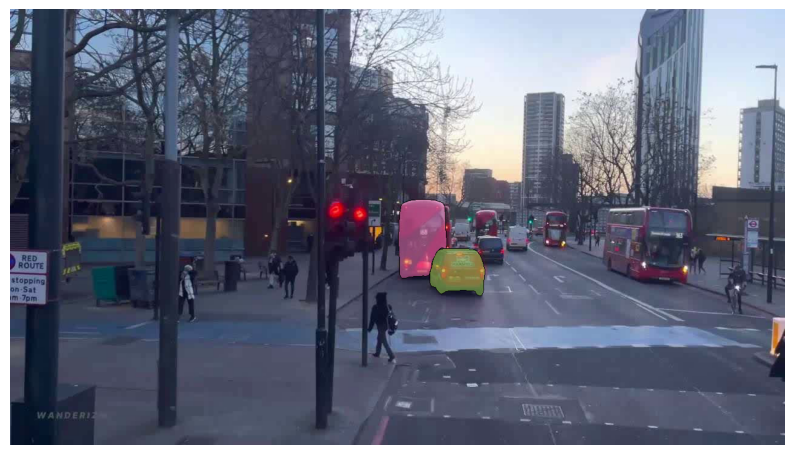

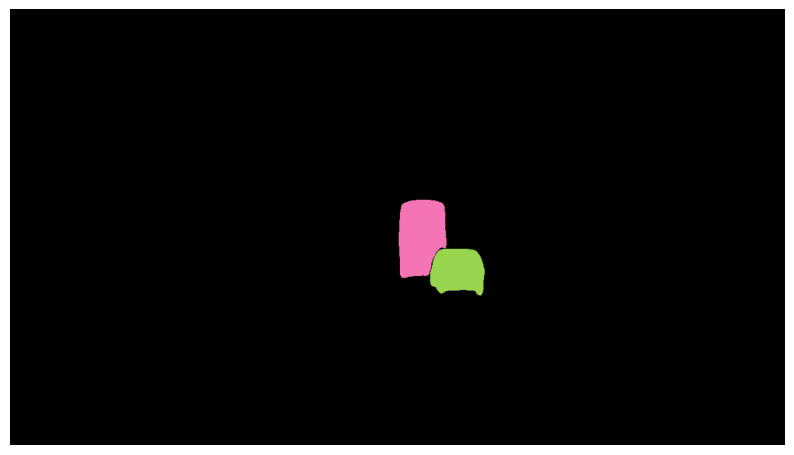

In [5]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {
        'points_per_side': 30,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 200,
    }

cap = cv2.VideoCapture(io_args['input_video'])
frame_idx = 0
segtracker = SegTracker(io_args, segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()

with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        
        pred_mask = segtracker.seg(frame)
        torch.cuda.empty_cache()
        obj_ids = np.unique(pred_mask)
        obj_ids = obj_ids[obj_ids!=0]
        
        print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
        break
    cap.release()
    # init_res = (frame*0.5+colorize_mask(pred_mask)*0.5).astype(np.uint8)
    init_res = draw_mask(frame,pred_mask,id_countour=False)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(colorize_mask(pred_mask))
    plt.show()

    del segtracker
    torch.cuda.empty_cache()
    gc.collect()

In [6]:
torch.cuda.empty_cache()

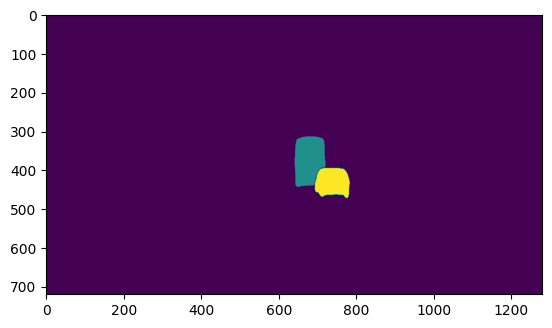

In [7]:
plt.imshow(pred_mask)

In [8]:
pred_mask.shape

(720, 1280)

In [9]:
np.unique(pred_mask)

array([0., 1., 2.])

### Generate Results for the Whole Video

In [10]:
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 8, # the interval to run sam to segment new objects
    'min_area': 500, # minimal mask area to add a new mask as a new object
    'max_obj_num': len(obj_ids), # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
}

# source video to segment
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = []
masked_pred_list = []

torch.cuda.empty_cache()
gc.collect()
sam_gap = segtracker_args['sam_gap']
frame_idx = 0
segtracker = SegTracker(io_args,segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()
frame_track = {}
with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        
        if frame_idx == 0:
            pred_mask = segtracker.seg(frame)
            frame_track[frame_idx] = pred_mask # Test Phuc
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
            
        elif (frame_idx % sam_gap) == 0:
            seg_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
#             fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
#             axs[0].imshow(colorize_mask(track_mask))
#             axs[0].set_xlabel("Track mask")
#             axs[1].imshow(colorize_mask(seg_mask))
#             axs[1].set_xlabel("Segmentation mask")
            
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)
#             plt.imshow(colo)
            save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            frame_track[frame_idx] = pred_mask # Test Phuc
            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
            
        else:
            pred_mask = segtracker.track(frame,update_memory=True)
            frame_track[frame_idx] = pred_mask # Test Phuc
        torch.cuda.empty_cache()
        gc.collect()
        
        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        # masked_frame = draw_mask(frame,pred_mask)
        # masked_pred_list.append(masked_frame)
        # plt.imshow(masked_frame)
        # plt.show() 
        
        #########################################
        # Cho mask của procontext vào đây
        #########################################
        pred_list.append(pred_mask)
        
        
        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1
    cap.release()
    print('\nfinished')

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
SegTracker has been initialized


KeyboardInterrupt: 

### Save results for visualization

In [5]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]
    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    out.write(masked_frame)
    print('frame {} writed'.format(frame_idx),end='\r')
    frame_idx += 1
out.release()
cap.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()

NameError: name 'pred_list' is not defined

In [8]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

KeyError: 'output_gif'

In [11]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()

476